In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from AtmoBuilder import AtmoBuilder

import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass

% matplotlib inline

In [2]:
WAVELENMIN = 300
WAVELENMAX = 1100
WAVELENSTEP = 0.1

STDPARAMETERS = [1.0,1.0,1.0,1.0,1.0,1.7]
STDAIRMASS = 1.2
STDAEROSOLNORMCOEFF = 0.1
STDAEROSOLNORMWAVELEN = 550.0
STDAEROSOLALPHA = STDPARAMETERS[5]

COLORS = ["u-g", "g-r", "r-i", "i-z", "z-y4"]

sedFiles = ["BC2003_0.571gyr_solar.sed0", "Sc_template_norm.sed0"]

In [3]:
ab = AtmoBuilder()

Found 16 MODTRAN files:
Pachon_MODTRAN.10.7sc
Pachon_MODTRAN.11.7sc
Pachon_MODTRAN.12.7sc
Pachon_MODTRAN.13.7sc
Pachon_MODTRAN.14.7sc
Pachon_MODTRAN.15.7sc
Pachon_MODTRAN.16.7sc
Pachon_MODTRAN.17.7sc
Pachon_MODTRAN.18.7sc
Pachon_MODTRAN.19.7sc
Pachon_MODTRAN.20.7sc
Pachon_MODTRAN.21.7sc
Pachon_MODTRAN.22.7sc
Pachon_MODTRAN.23.7sc
Pachon_MODTRAN.24.7sc
Pachon_MODTRAN.25.7sc
MODTRAN files have been read.

Read filter data from LSST software stack.
Filters: ['u', 'g', 'r', 'i', 'z', 'y4']
Read hardware data from LSST software stack.


In [4]:
def readSedAndRedshift(sedFile, redshiftRange=[0, 3.0], redshiftStep=0.001, addDust=True):
    
    wavelength_angstroms, fnu = np.loadtxt(sedFile, unpack=True)
    wavelength_nm = wavelength_angstroms*0.1
    baseSed = Sed(wavelen=wavelength_nm, fnu=fnu)
        
    seds = {}
    sedkeylist = []
    redshifts = np.arange(redshiftRange[0], redshiftRange[1] + redshiftStep, redshiftStep)
    for z in redshifts:
        sedname = "%s_%.3f" % (sedFile, z)
        wavelen, flambda = baseSed.redshiftSED(z, wavelen=baseSed.wavelen, flambda=baseSed.flambda)
        seds[sedname] = Sed(wavelen=wavelen, flambda=flambda)
        sedkeylist.append(sedname)
            
    for sed in sedkeylist:
        seds[sed].synchronizeSED(wavelen_min=WAVELENMIN, wavelen_max=WAVELENMAX, wavelen_step=WAVELENSTEP)
    
    if addDust:
        ax, bx = seds[sedkeylist[0]].setupCCMab()
        for sed in sedkeylist:
            seds[sed].addCCMDust(ax, bx, A_v=0.02)
        
    return seds, sedkeylist, redshifts

def buildPanel(seds, sedkeylist, redshifts, airmass=1.0, parameters=[1.0,1.0,1.0,1.0,1.0,1.7]):
    atmo = ab.buildAtmo(parameters, airmass)
    throughput = ab.combineThroughputs(atmo)
    mags = ab.mags(throughput, seds=seds, sedkeylist=sedkeylist)
    
    color_dict = {}
    for color in COLORS:
        filters = color.split("-")
        color_dict[color] = mags[filters[0]] - mags[filters[1]]

    panel = np.zeros(len(sedkeylist), 
            dtype={"names":["z", "u-g", "g-r", "r-i", "i-z", "z-y4"], 
                    "formats":["float64","float64","float64","float64","float64","float64"]})
    
    panel["z"] = redshifts
    for color in COLORS:
        panel[color] = color_dict[color]
        
    df = pd.DataFrame(panel, columns=["z", "u-g", "g-r", "r-i", "i-z", "z-y4"])
    return df
    
def buildTable(sedFile, airmasses=[1.0,1.5,2.0], parameters=[1.0,1.0,1.0,1.0,1.0,1.7], redshiftRange=[0, 4.0], redshiftStep=0.001, addDust=True):
    
    seds, sedkeylist, redshifts = readSedAndRedshift(sedFile, redshiftRange=redshiftRange, redshiftStep=redshiftStep, addDust=addDust)

    panels = []
    for airmass in airmasses:
        panels.append(buildPanel(seds, sedkeylist, redshifts, airmass=airmass, parameters=parameters))

    return pd.concat(panels, keys=airmasses)

In [5]:
BC = buildTable(sedFiles[0])

In [6]:
BC

z       u-g       g-r       r-i       i-z      z-y4
1.0 0     0.000  0.637291 -0.322809 -0.303299 -0.218863 -0.170111
    1     0.001  0.642287 -0.322240 -0.303034 -0.219490 -0.169298
    2     0.002  0.649003 -0.321965 -0.302790 -0.219331 -0.169148
    3     0.003  0.654477 -0.321435 -0.302287 -0.218737 -0.170333
    4     0.004  0.659051 -0.321000 -0.302446 -0.219103 -0.169618
    5     0.005  0.664973 -0.319351 -0.302375 -0.220046 -0.169403
    6     0.006  0.668486 -0.317477 -0.302980 -0.218831 -0.170440
    7     0.007  0.671619 -0.316867 -0.301925 -0.219342 -0.169655
    8     0.008  0.677100 -0.315718 -0.302081 -0.218814 -0.169659
    9     0.009  0.682132 -0.314205 -0.302633 -0.218561 -0.170041
    10    0.010  0.686343 -0.314202 -0.302322 -0.218903 -0.169533
    11    0.011  0.692166 -0.314022 -0.301246 -0.219319 -0.169511
    12    0.012  0.696662 -0.312557 -0.301827 -0.218788 -0.169717
    13    0.013  0.700997 -0.310927 -0.301676 -0.219503 -0.169204
    14    0.014  0.707372 -0.309783 -0.301881 -0.218768 -0.169362
    15    0.015  0.710932 -0.309132 -0.301140 -0.219510 -0.169208
    16    0.016  0.714628 -0.309092 -0.301008 -0.219884 -0.168591
    17    0.017  0.722393 -0.308664 -0.300066 -0.219594 -0.169704
    18    0.018  0.727448 -0.307318 -0.300939 -0.219388 -0.169450
    19    0.019  0.728439 -0.305545 -0.301149 -0.220304 -0.168975
    20    0.020  0.733933 -0.304425 -0.300953 -0.219719 -0.169180
    21    0.021  0.739468 -0.303484 -0.300216 -0.220087 -0.168783
    22    0.022  0.741093 -0.302528 -0.299826 -0.220655 -0.168198
    23    0.023  0.745142 -0.301575 -0.300375 -0.219416 -0.168797
    24    0.024  0.750535 -0.300731 -0.299722 -0.220406 -0.168580
    25    0.025  0.753066 -0.299497 -0.300019 -0.219783 -0.168936
    26    0.026  0.755796 -0.297741 -0.299717 -0.220548 -0.168692
    27    0.027  0.759821 -0.296246 -0.299662 -0.220412 -0.168773
    28    0.028  0.762782 -0.295142 -0.299854 -0.219926 -0.168679
    29    0.029  0.765870 -0.293852 -0.299491 -0.220862 -0.168401
...         ...       ...       ...       ...       ...       ...
2.0 3972  3.972  0.085087  0.991412  2.444235  1.299200  0.274607
    3973  3.973  0.085080  0.988658  2.445163  1.299859  0.275374
    3974  3.974  0.085084  0.985895  2.446109  1.300511  0.276131
    3975  3.975  0.085067  0.983124  2.447054  1.301181  0.276882
    3976  3.976  0.085074  0.980326  2.447976  1.301866  0.277645
    3977  3.977  0.085058  0.977550  2.448913  1.302543  0.278392
    3978  3.978  0.085054  0.974772  2.449830  1.303218  0.279139
    3979  3.979  0.085051  0.971969  2.450732  1.303925  0.279896
    3980  3.980  0.085048  0.969156  2.451662  1.304627  0.280641
    3981  3.981  0.085059  0.966338  2.452582  1.305309  0.281402
    3982  3.982  0.085044  0.963539  2.453479  1.306026  0.282171
    3983  3.983  0.085043  0.960714  2.454397  1.306742  0.282928
    3984  3.984  0.085042  0.957883  2.455325  1.307447  0.283696
    3985  3.985  0.085042  0.955063  2.456229  1.308160  0.284468
    3986  3.986  0.085043  0.952237  2.457140  1.308882  0.285228
    3987  3.987  0.085044  0.949399  2.458065  1.309590  0.286002
    3988  3.988  0.085045  0.946557  2.458989  1.310305  0.286770
    3989  3.989  0.085045  0.943730  2.459895  1.311030  0.287528
    3990  3.990  0.085047  0.940888  2.460814  1.311745  0.288307
    3991  3.991  0.085050  0.938041  2.461751  1.312451  0.289081
    3992  3.992  0.085054  0.935194  2.462679  1.313166  0.289856
    3993  3.993  0.085057  0.932356  2.463596  1.313880  0.290643
    3994  3.994  0.085059  0.929505  2.464537  1.314583  0.291429
    3995  3.995  0.085061  0.926657  2.465471  1.315293  0.292215
    3996  3.996  0.085064  0.923805  2.466409  1.316005  0.293000
    3997  3.997  0.085068  0.920958  2.467345  1.316712  0.293786
    3998  3.998  0.085071  0.918106  2.468291  1.317419  0.294573
    3999  3.999  0.085075  0.915251  2.469241  1.318127  0.295361
    4000  4.000  0.085078  0.912391  2.470193  1.31883

In [7]:
Sc = buildTable(sedFiles[1])

In [8]:
Sc

z        u-g       g-r       r-i       i-z      z-y4
1.0 0     0.000   0.774773  0.067711 -0.117101 -0.051993 -0.022854
    1     0.001   0.776380  0.069175 -0.117428 -0.051831 -0.022345
    2     0.002   0.777932  0.070668 -0.117753 -0.051668 -0.021828
    3     0.003   0.779419  0.072191 -0.118081 -0.051504 -0.021324
    4     0.004   0.780829  0.073737 -0.118398 -0.051334 -0.020802
    5     0.005   0.782172  0.075295 -0.118689 -0.051184 -0.020256
    6     0.006   0.783449  0.076864 -0.118945 -0.051084 -0.019703
    7     0.007   0.784711  0.078438 -0.119175 -0.051035 -0.019130
    8     0.008   0.785951  0.080009 -0.119363 -0.051061 -0.018534
    9     0.009   0.787195  0.081585 -0.119522 -0.051166 -0.017946
    10    0.010   0.788472  0.083145 -0.119622 -0.051354 -0.017395
    11    0.011   0.789757  0.084717 -0.119676 -0.051604 -0.016860
    12    0.012   0.791038  0.086284 -0.119678 -0.051934 -0.016306
    13    0.013   0.792310  0.087854 -0.119651 -0.052290 -0.015817
    14    0.014   0.793571  0.089431 -0.119601 -0.052667 -0.015352
    15    0.015   0.794743  0.090996 -0.119535 -0.053078 -0.014845
    16    0.016   0.795910  0.092583 -0.119469 -0.053477 -0.014344
    17    0.017   0.796928  0.094206 -0.119412 -0.053882 -0.013852
    18    0.018   0.797837  0.095852 -0.119358 -0.054310 -0.013315
    19    0.019   0.798664  0.097483 -0.119251 -0.054760 -0.012722
    20    0.020   0.799388  0.099111 -0.119121 -0.055222 -0.012133
    21    0.021   0.799966  0.100796 -0.118993 -0.055660 -0.011571
    22    0.022   0.800504  0.102484 -0.118848 -0.056105 -0.011022
    23    0.023   0.800933  0.104178 -0.118695 -0.056586 -0.010487
    24    0.024   0.801358  0.105873 -0.118486 -0.057126 -0.010008
    25    0.025   0.801751  0.107547 -0.118219 -0.057712 -0.009573
    26    0.026   0.802071  0.109237 -0.117936 -0.058324 -0.009144
    27    0.027   0.802451  0.110935 -0.117641 -0.058936 -0.008706
    28    0.028   0.802905  0.112624 -0.117337 -0.059527 -0.008267
    29    0.029   0.803186  0.114344 -0.117038 -0.060133 -0.007803
...         ...        ...       ...       ...       ...       ...
2.0 3972  3.972  13.021647  1.397056  0.018194 -0.177248 -0.193316
    3973  3.973  13.019074  1.399380  0.018724 -0.177242 -0.193392
    3974  3.974  13.016491  1.401723  0.019238 -0.177228 -0.193461
    3975  3.975  13.013906  1.404047  0.019765 -0.177202 -0.193531
    3976  3.976  13.011371  1.406348  0.020266 -0.177183 -0.193592
    3977  3.977  13.008767  1.408700  0.020783 -0.177159 -0.193653
    3978  3.978  13.006175  1.411049  0.021282 -0.177126 -0.193712
    3979  3.979  13.003568  1.413403  0.021787 -0.177090 -0.193766
    3980  3.980  13.000958  1.415772  0.022284 -0.177052 -0.193818
    3981  3.981  12.998393  1.418089  0.022779 -0.177009 -0.193870
    3982  3.982  12.995763  1.420467  0.023275 -0.176958 -0.193912
    3983  3.983  12.993131  1.422847  0.023771 -0.176905 -0.193958
    3984  3.984  12.990496  1.425239  0.024257 -0.176849 -0.194002
    3985  3.985  12.987858  1.427626  0.024749 -0.176788 -0.194036
    3986  3.986  12.985247  1.429987  0.025239 -0.176724 -0.194073
    3987  3.987  12.982592  1.432392  0.025727 -0.176659 -0.194104
    3988  3.988  12.979929  1.434805  0.026214 -0.176592 -0.194128
    3989  3.989  12.977264  1.437219  0.026702 -0.176522 -0.194155
    3990  3.990  12.974595  1.439635  0.027190 -0.176450 -0.194174
    3991  3.991  12.971942  1.442035  0.027678 -0.176377 -0.194192
    3992  3.992  12.969255  1.444473  0.028163 -0.176303 -0.194210
    3993  3.993  12.966563  1.446911  0.028650 -0.176225 -0.194224
    3994  3.994  12.963867  1.449351  0.029138 -0.176148 -0.194238
    3995  3.995  12.961167  1.451795  0.029626 -0.176069 -0.194250
    3996  3.996  12.958467  1.454241  0.030112 -0.175989 -0.194259
    3997  3.997  12.955747  1.456704  0.030600 -0.175908 -0.194268
    3998  3.998  12.953024  1.459170  0.031089 -0.175825 -0.194270
    3999  3.999  12.950297  1.461639  0.031578 -0.175743 -0.1

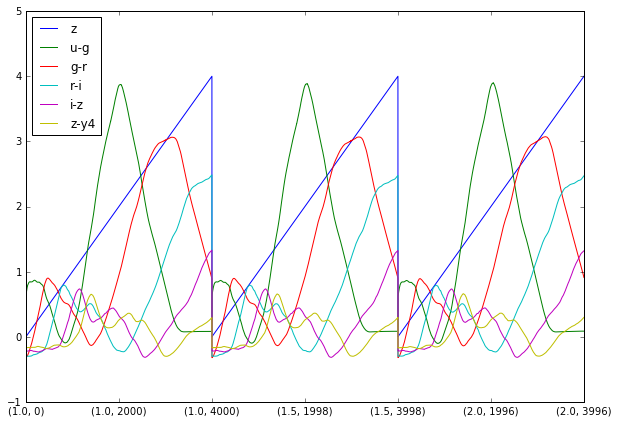

In [13]:
# Pretty but not very clear
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
BC.plot(ax=ax)

In [10]:
### SANITY CHECK ###
# As a sanity check, I’d expect that the colors are very similar for the first
# galaxy (BC) at z=0.38 and the second one (Sc) at z=3.55. 
BC_test = buildTable(sedFiles[0], airmasses=[1.0], redshiftRange=[0,3.6])
Sc_test = buildTable(sedFiles[1], airmasses=[1.0], redshiftRange=[0,3.6])

In [11]:
BC_test.loc[1.0, 380]

z       0.380000
u-g     0.752851
g-r     0.739558
r-i    -0.206615
i-z    -0.205799
z-y4   -0.167985
Name: (1.0, 380), dtype: float64

In [12]:
Sc_test.loc[1.0, 3550]

z        3.550000
u-g     13.700721
g-r      0.798581
r-i     -0.194813
i-z     -0.204144
z-y4    -0.144618
Name: (1.0, 3550), dtype: float64